In [1]:
!pip3 install -q --upgrade --user git+https://github.com/pymc-devs/pymc4.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


# Hierarchical radon model

(c) 2019 Thomas Wiecki, Junpeng Lao

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

In [30]:
@pm.model
def hierarchical_model(data, county_idx):
    # Hyperpriors
    mu_a = yield pm.Normal('mu_alpha', mu=0., sigma=1)
    sigma_a = yield pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = yield pm.Normal('mu_beta', mu=0., sigma=1)
    sigma_b = yield pm.HalfCauchy('sigma_beta', beta=1)

    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal('alpha', mu=mu_a, sigma=sigma_a, plate=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal('beta', mu=mu_b, sigma=sigma_b, plate=len(data.county.unique()))

    # Model error
    eps = yield pm.HalfCauchy('eps', beta=1)

    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal('y_like', mu=radon_est, sigma=eps, observed=data.log_radon)

### Mass matrix adaptation
Essentially, we are doing a 2 window adaptation similar to Stan below: dual averaging for burn_in samples, and then normal sample for diagonal mass matrix estimation.

In [2]:
def sample(model, init_num_chains=50, num_samples=500, burn_in=500):
    init_num_chains = 50
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=init_num_chains, num_samples=10, burn_in=10, step_size=1., xla=True)
    for i in range(3):
        step_size_ = []
        for _, x in pm4_trace.items():
            std = tf.math.reduce_std(x, axis=[0, 1])
            step_size_.append(
                std[tf.newaxis, ...] * tf.ones([init_num_chains] + std.shape, dtype=std.dtype))
        pm4_trace, _ = pm.inference.sampling.sample(
            model, num_chains=init_num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i,
            step_size=step_size_, xla=True)
        
    num_chains = 5
    step_size_ = []
    for _, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

    pm4_trace, sample_stat = pm.inference.sampling.sample(
        model, num_chains=num_chains, num_samples=num_samples, burn_in=burn_in,
        step_size=step_size_, xla=True)
    
    az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)
    
    return az_trace

In [31]:
model = hierarchical_model(data, county_idx)
az_trace = sample(model)

In [32]:
np.mean(np.exp(az_trace.sample_stats['mean_tree_accept']), axis=1)

<xarray.DataArray 'mean_tree_accept' (chain: 5)>
array([0.793202, 0.706977, 0.759746, 0.88162 , 0.674618], dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4

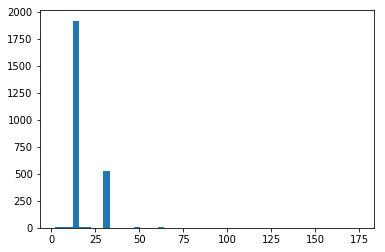

In [33]:
plt.hist(np.ravel(az_trace.sample_stats['tree_size']), 50);

In [34]:
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hierarchical_model/mu_beta,-0.639,0.078,-0.778,-0.477,0.003,0.002,683.0,681.0,676.0,1175.0,1.01
hierarchical_model/alpha[0],1.203,0.248,0.740,1.659,0.006,0.004,1837.0,1837.0,1754.0,1557.0,1.00
hierarchical_model/alpha[1],0.988,0.095,0.824,1.175,0.002,0.002,1562.0,1460.0,1549.0,1554.0,1.01
hierarchical_model/alpha[2],1.497,0.272,0.983,1.989,0.006,0.005,1781.0,1701.0,1774.0,1306.0,1.00
hierarchical_model/alpha[3],1.538,0.230,1.100,1.959,0.006,0.005,1305.0,1267.0,1315.0,583.0,1.01
hierarchical_model/alpha[4],1.465,0.249,0.986,1.919,0.009,0.007,728.0,596.0,777.0,439.0,1.01
hierarchical_model/alpha[5],1.486,0.268,0.975,1.960,0.011,0.008,627.0,627.0,683.0,297.0,1.01
hierarchical_model/alpha[6],1.846,0.171,1.525,2.164,0.003,0.002,2489.0,2408.0,2481.0,1500.0,1.01
hierarchical_model/alpha[7],1.697,0.256,1.235,2.200,0.006,0.004,2028.0,2019.0,2022.0,1487.0,1.01
hierarchical_model/alpha[8],1.177,0.183,0.844,1.515,0.005,0.003,1549.0,1549.0,1605.0,1334.0,1.00


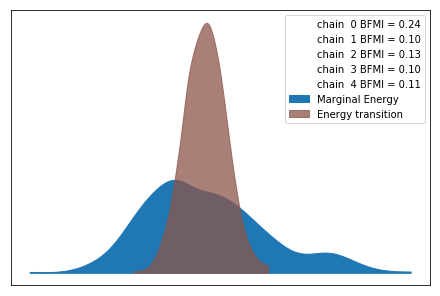

In [35]:
az.plot_energy(az_trace);

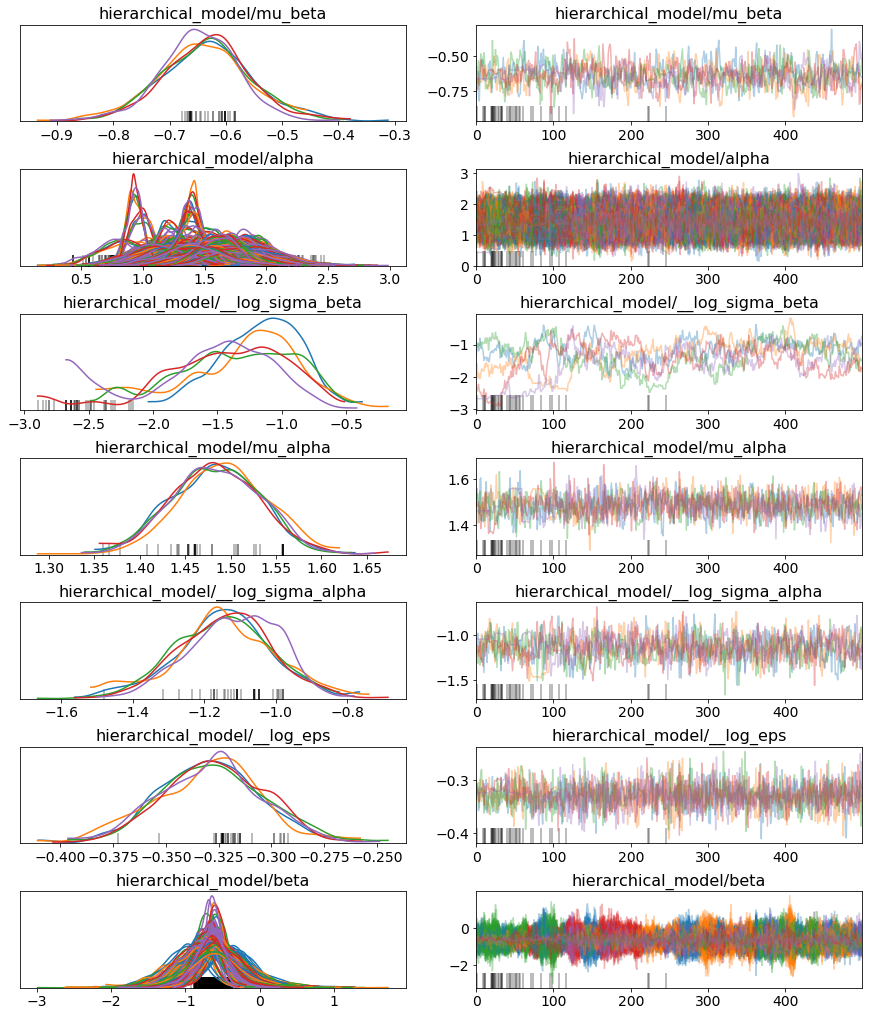

In [36]:
az.plot_trace(az_trace, compact=True);

## Models are just distributions

In [15]:
@pm.model
def Hierarchical(n, centered=True):
    mu = yield pm.Normal('mu', mu=0., sigma=1)
    sigma = yield pm.HalfCauchy('sigma', beta=1)
    if centered:
        s = yield pm.Normal('s', mu=mu, sigma=sigma, 
                            plate=n)
    else:
        offset = yield pm.Normal('offset', mu=0, sigma=1, 
                                 plate=n)
        s = mu + sigma * offset
    return s
    
@pm.model
def hierarchical_model_nc(data, county_idx):
    n = len(data.county.unique())
    # Intercept for each county, distributed around group mean mu_a
    a = yield Hierarchical(n=n, centered=False, name='alpha')
    # Intercept for each county, distributed around group mean mu_a
    b = yield Hierarchical(n=n, centered=False, name='beta')

    # Model error
    eps = yield pm.HalfCauchy('eps', beta=1)

    # Expected value
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood    
    y_like = yield pm.Normal('y_like', mu=radon_est, sigma=eps, observed=data.log_radon)

In [16]:
model = hierarchical_model_nc(data, county_idx)
az_trace_nc = sample(model)

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo


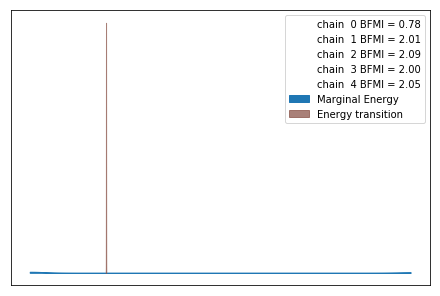

In [17]:
az.plot_energy(az_trace_nc);

/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anacond

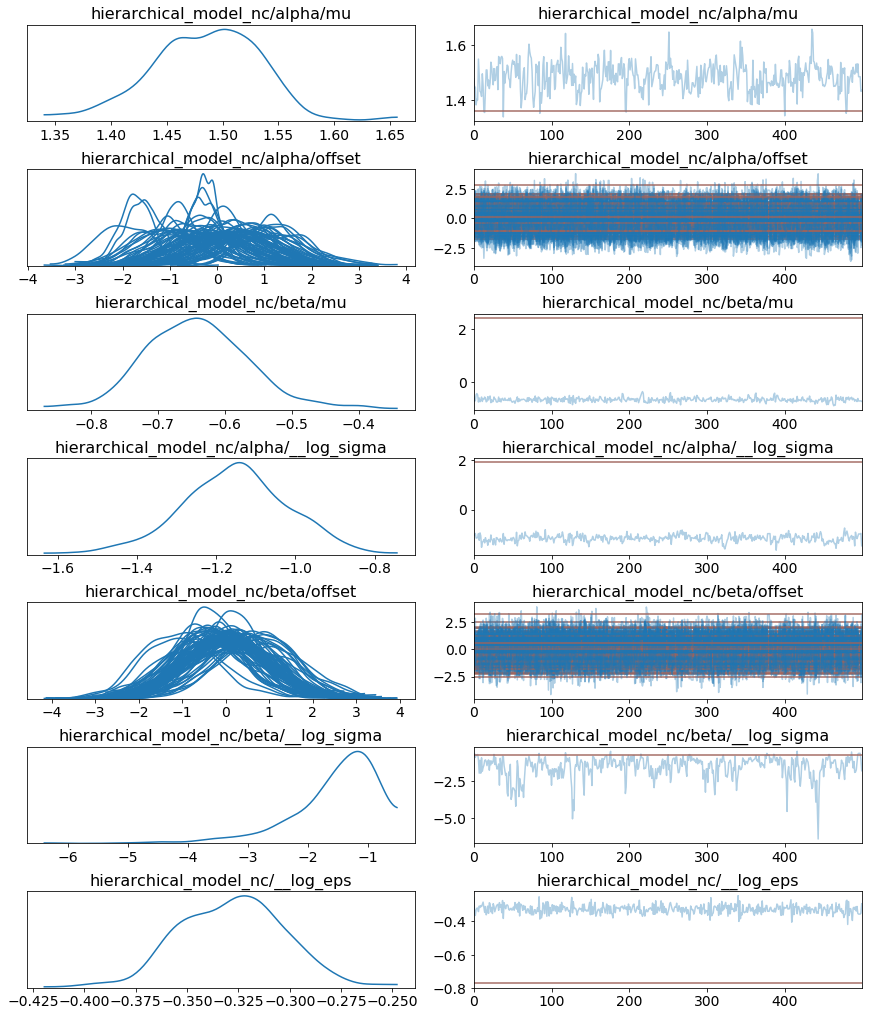

In [18]:
az.plot_trace(az_trace_nc, compact=True);